# Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix, adjusted_rand_score

model_results_dir = './model_results/'
if not os.path.isdir(model_results_dir):
    os.mkdir(model_results_dir)

%matplotlib inline

from mbcah import (
    sampling,
    plotting,
    two_steps_fit,
    model_selection,
)
from mbcah.utils import similarity_matrices

# Sampling data

In [2]:
# problem size
N = 300  # number of curves
T = 200  # number of timesteps
K = 3  # number of clusters
S = np.arange(0, T // 4, 3)  # set of shifts

# mixture proportions
alpha_rho = 1.  # parameter of the dirichlet used to sample parameter rho
alpha_gamma = 1. # parameter of the dirichlet used to sample parameter gamma

# prototypes
sigma2_gp_mu = 1e-3  # controls the smoothness of the mu_k

# variances
constrained_sigma2 = 'sigma_k'  # sigma_jk, sigma_k
s2 = 5e-1 * np.linspace(.1, 1, K)  # constant variance term in each cluster 
sigma2_gp_sigma2 = 1e-1 # controls the smoothness of the sigma2_jk, unused if constrained_sigma2 == 'sigma_k'

# mask for missing data
n_intervals = 20  # number of blocks of potential missing data
p_missing = .2  # probability that a block of data is missing

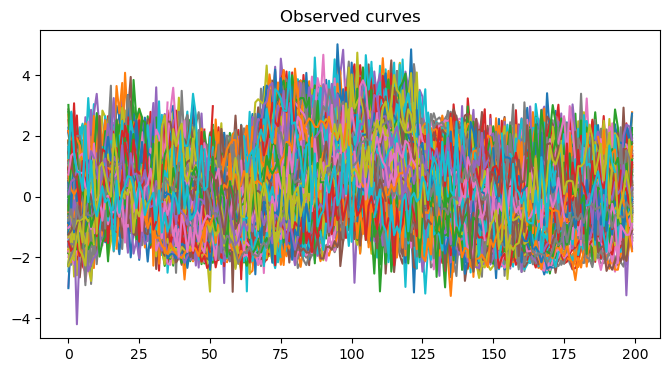

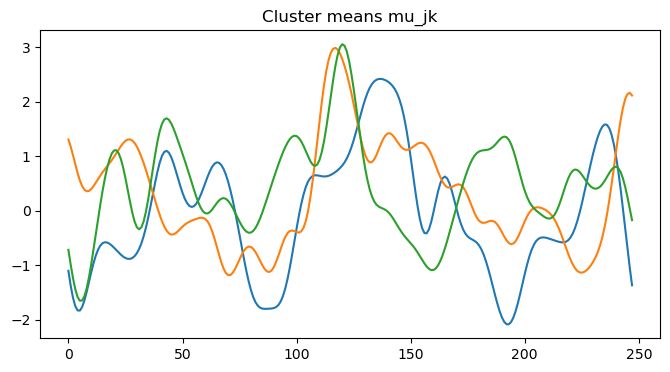

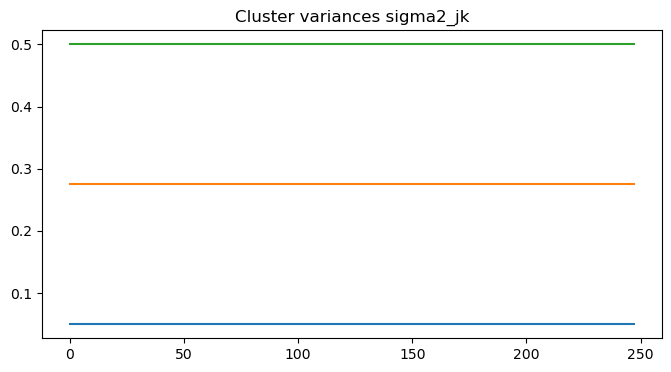

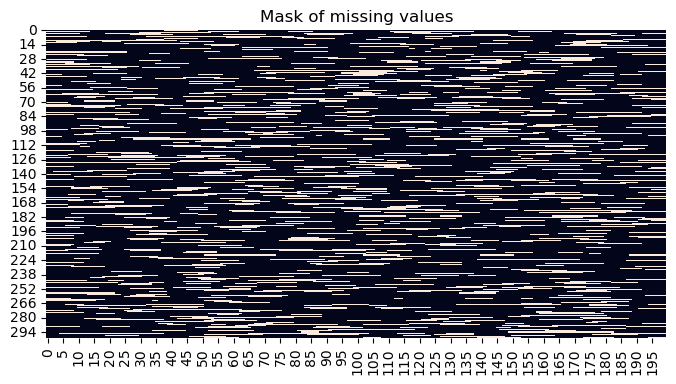

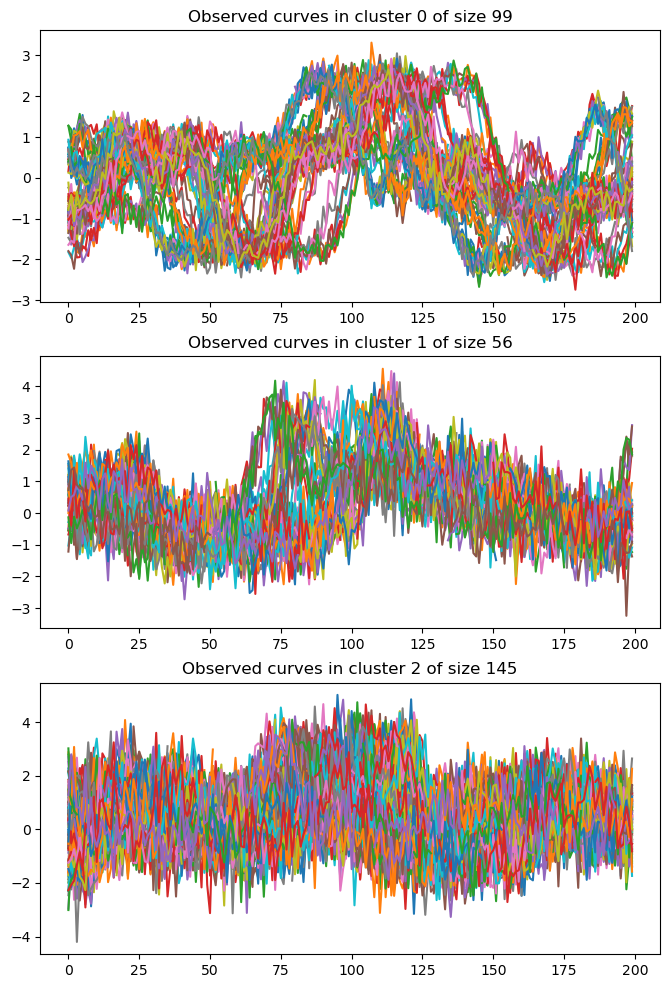

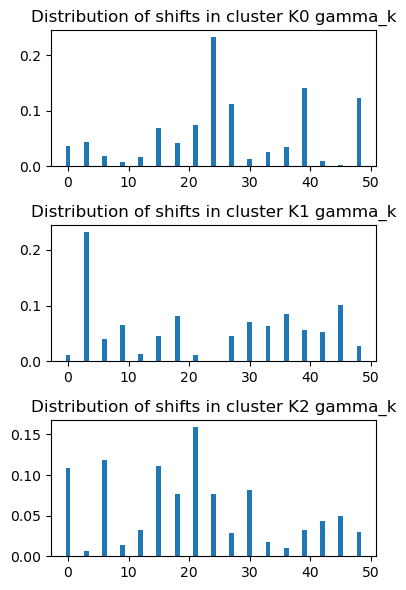

In [3]:
reproducible = True  # True, False
random_state = np.random.default_rng(1234) if reproducible else np.random
dtype = 'float64'

sampler = sampling.Sampler(
    N, T, K, S,
    alpha_rho,
    alpha_gamma,
    constrained_sigma2,
    sigma2_gp_mu,
    sigma2_gp_sigma2,
    s2,
    n_intervals,
    p_missing,
    random_state,
    dtype
)
sampler.sample()

plt.figure(figsize=(8, 4))
plt.plot(sampler.X.T)
plt.title('Observed curves')

plt.figure(figsize=(8, 4))
plt.plot(sampler.mu)
plt.title('Cluster means mu_jk')

plt.figure(figsize=(8, 4))
plt.plot(sampler.sigma2)
plt.title('Cluster variances sigma2_jk')

f, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(sampler.mask, ax=ax, cbar=False)
ax.set_title('Mask of missing values');

sizes = sampler.z.sum(0)
f, ax = plt.subplots(sampler.K, figsize=(8, 4 * sampler.K))
for k in range(K):
    ax[k].plot(sampler.X[sampler.Z == k].T)
    ax[k].set_title(f'Observed curves in cluster {k} of size {sizes[k]}')

f, ax = plt.subplots(sampler.K, figsize=(4, 2 * sampler.K), tight_layout=True)
for k in range(sampler.K):
    ax[k].bar(sampler.S, sampler.gamma[k])
    ax[k].set_title(f'Distribution of shifts in cluster K{k} gamma_k');

# Model

## Build semi-supervision

Choose one between "Unsupervised" and "Semi-supervised"

### Unsupervised

In [4]:
C = None

### Semi-supervised

In [5]:
# here, the constraint matrix C is build using the true partition sampler.Z
frac = .005  # the fraction of the N(N-1)/2 constraints given to the model
frac_noise = 0.  # the fraction of the cells of the constraint matrix that are flipped : Must Link becomes Cannot Link and vice versa

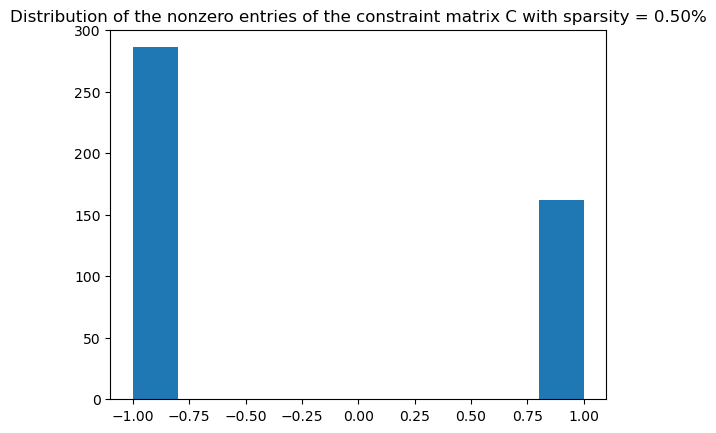

In [6]:
C = similarity_matrices.build_C(sampler.Z, frac, frac_noise)
sparsity = 100 * (C != 0).sum() / C.size
plt.hist(C[C != 0].flatten());
plt.title(f'Distribution of the nonzero entries of the constraint matrix C with {sparsity = :.2f}%');

## Fit model

### Set parameters

In [7]:
# range for the number of clusters
Ks = [2, 3, 4]  # number of clusters tested in model selection

# semi supervision
etas_min, etas_max, n_steps = 100., 1000., 10
etas = np.linspace(etas_min, etas_max, n_steps)  # values of the HMRF scaling factor eta tested in model selection
full_sequential = True

# model parameters
constrained_gamma = 'gamma_km'  # gamma, gamma_m, gamma_km
constrained_sigma2 = sampler.constrained_sigma2

# priors
alpha_zero = 1.1  # set to 1.1 for ML estimation
beta_zero = 1.1  # set to 1.1 for ML estimation
prior_sigma2 = 'minimum_dof'  # minimum_dof, no_prior 

# EM algorithm
em_type_first_step = 'CEM'  # SEM, CEM, VEM, EM
em_type_second_step = 'VEM' # SEM, CEM, VEM, EM
n_init_first_step = 10
n_selected_inits = 1
n_init_second_step_per_selected_init = 5
max_iter_em = 40

# parallelism
n_processes = -1  # the number of processes used

# initialization
coarsening_factor = 3  # integer >= 1 used in the initialization : larger coarsening_factor implies faster but less optimal initialization

### Run

In [8]:
random_state = sampler.random_state
nu_zero = (
    T + sampler.S.max() + 2
    if prior_sigma2 == 'minimum_dof'
    else
    None
)
etas = [0] if C is None else etas
model_results = two_steps_fit.parallel_fit_over_etas(
    X=sampler.X,
    Ks=Ks,
    S=S,
    etas=etas,
    C=C,
    full_sequential=full_sequential,
    n_init_first_step=n_init_first_step,
    n_selected_inits=n_selected_inits,
    n_init_second_step_per_selected_init=n_init_second_step_per_selected_init,
    em_type_first_step=em_type_first_step,
    em_type_second_step=em_type_second_step,
    constrained_gamma=constrained_gamma,
    constrained_sigma2=constrained_sigma2,
    alpha_zero=alpha_zero,
    beta_zero=beta_zero,
    nu_zero=nu_zero,
    coarsening_factor=coarsening_factor,
    max_iter_em=max_iter_em,
    n_processes=n_processes,
    model_results_dir=model_results_dir,
)

--- Data of shape N, T = (300, 200)
    with 19.57% of missing values

--- Model: 
    Ks = [2, 3, 4]
    sigma structure sigma_k
    gamma structure gamma_km
    no semi-supervision
    algo_init_partition kmeans
    n_init_km 10
    algo_init_tau sim
    coarsening_factor 3
    cluster_perturbation_rate 0.3



fit for different K and eta: 100%|████████████████████████████████████████████████████████████████████████████████████| 30/30 [07:00<00:00, 36.83s/it][Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.0min finished
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  7.0min remaining:    0.0s
fit for different K and eta: 100%|████████████████████████████████████████████████████████████████████████████████████| 30/30 [07:00<00:00, 14.03s/it]


## Convergence and criterions

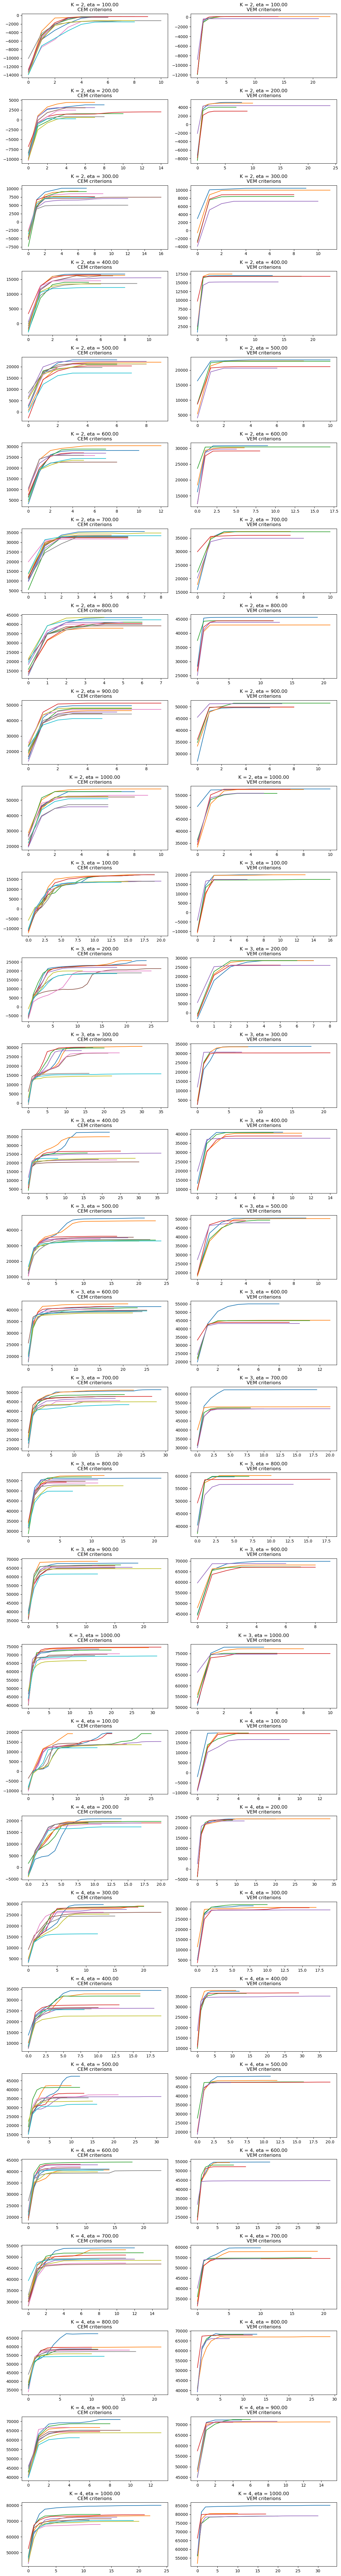

In [9]:
em_types = set([mr.em_type for mr in model_results])
semi_supervised = C is not None and etas.size > 0
n_variable_params = len(etas) * len(Ks)

f, ax = plt.subplots(
    n_variable_params, len(em_types), 
    figsize=(6 * len(em_types), 3 * n_variable_params), 
    sharey=False, squeeze=False, tight_layout=True
)

i = 0
for k in Ks:
    for eta in etas:
        for j, em_type in enumerate(em_types):
            for mr in model_results:
                if mr.em_type == em_type and mr.K == k and (not mr.semi_supervised or mr.eta == eta):
                    ax[i, j].plot(mr.iter_criterions)
                    ax[i, j].set_title(f'K = {k}, {eta = :.2f}\n{em_type} criterions')
        i += 1

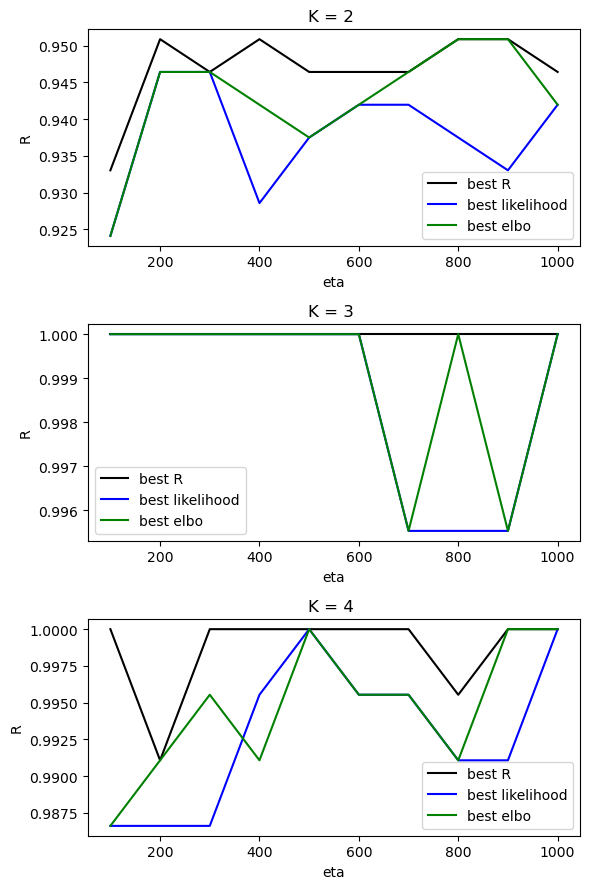

In [10]:
plotting.plot_similarity_scores(model_results)

## Model selection

In [11]:
min_R = .0

Found K = 3 and eta = 200.00


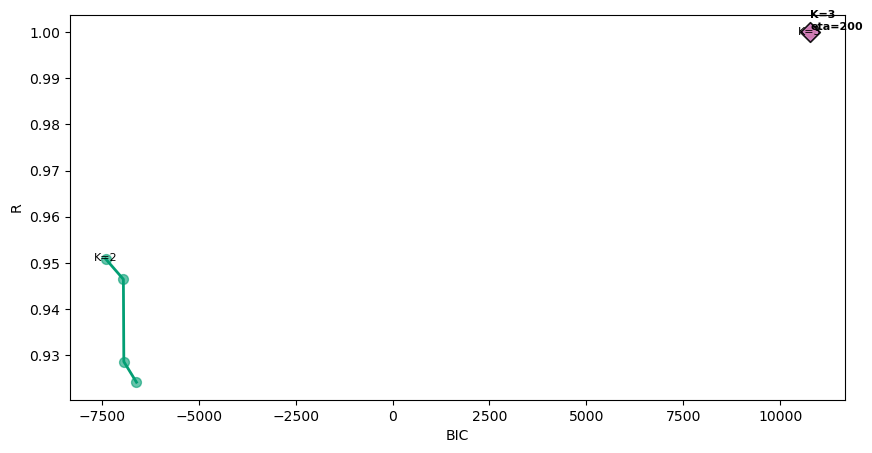

In [12]:
crit1, crit2 = 'bic', 'scw'
df_res = model_selection.get_metrics_df(model_results)
df_res = model_selection.assign_pareto_efficient(df_res, crit1, crit2)

fs = 8
fs_selcted = 8
scatter_size = 50.
selected_size = 800.

y_offset = .0002
lw = 2.

if not semi_supervised:
    K_found = Ks[np.argmax(df_res.groupby('K').agg({crit1: 'max'}).values)]
    df_bic = df_res.query("K == @K_found")

    mr_id = df_bic.iloc[[np.argmax(df_bic[crit1].values)]].mr_id.values[0]
    model_result = [mr for mr in model_results if mr.mr_id == mr_id].pop()
else:
    df_res_filtered = (
        df_res
        .query("K_pareto_efficient")
        .query("scw >= @min_R")
    )
    assert df_res_filtered.size >= 2, 'value of min_R is too high'
    X_crits_eff = df_res_filtered[[crit1, crit2]].values
    selected_point = model_selection.heuristic_model_selection_on_pareto_front(
        X_crits_eff, method='farthest'
    )
    selected_mr_id = df_res_filtered.iloc[selected_point].mr_id
    model_result = [
        mr
        for mr in model_results
        if mr.mr_id == df_res_filtered.iloc[selected_point].mr_id
    ].pop()

    d = df_res_filtered.query("mr_id == @selected_mr_id")
    x_plot, y_plot, k_plot = d[crit1], d[crit2], k
    first_model = {}

    f, ax = plt.subplots(1, 1, figsize=(10, 5))
    n_colors = np.unique(df_res_filtered['K']).size
    cmap = sns.color_palette('colorblind', n_colors, as_cmap=True)

    for k, g in df_res_filtered.groupby('K'):
        ax.scatter(
            g[crit1], g[crit2],
            s=scatter_size, alpha=.6, color=cmap[k % len(cmap)], zorder=1
        )  
        x, y = g[crit1].values, g[crit2].values
        order = np.argsort(x)
        first_model[k] = g.mr_id.values[order][0]
        ax.plot(
            x[order], y[order],
            color=cmap[k % len(cmap)], zorder=1, lw=lw
        )
    ax.scatter(
        x_plot, y_plot,
        s=2 * scatter_size, alpha=.9, color=cmap[k_plot % len(cmap)],
        edgecolor='k', linewidth=1.2, zorder=2, marker='D'
    )

    for i, (x, y, k, eta, mr_id) in enumerate(zip(
            df_res_filtered[crit1],
            df_res_filtered[crit2],
            df_res_filtered.K,
            df_res_filtered.eta,
            df_res_filtered.mr_id
        )):
        if i == selected_point:
            text = (
                'K=' + str(k) + '\n' + 
                'eta=' + str(eta).split('.')[0]
            )
            ax.text(
                x, y + y_offset, text, fontsize=fs_selcted,
                verticalalignment='bottom', horizontalalignment='left', zorder=2, weight='bold'
            )
        if mr_id == first_model[k]:
            text = 'K=' + str(k)
            ax.text(
                x, y + y_offset, text, fontsize=fs,
                verticalalignment='center', horizontalalignment='center', zorder=2
            )

    ax.set_xlabel('BIC');
    ax.set_ylabel('R');
    
model_result.load_shallow_from_pickle()
if not model_result.write_params:
    print('Model is empty')

print(f'Found K = {model_result.K} and eta = {model_result.eta:.2f}')

# Metrics

In [13]:
if C is not None:
    if (C > 0.).any():
        _, R = similarity_matrices.similarity_concordance(model_result.Z, np.clip(C, 0, None))
        print(f'ML {R = :.4f}')
    if (C < 0.).any():
        _, R = similarity_matrices.similarity_concordance(model_result.Z, np.clip(C, None, 0))
        print(f'CL {R = :.4f}')
    _, R = similarity_matrices.similarity_concordance(model_result.Z, C)
    print(f'ALL {R = :.4f}')
    print()

ari = adjusted_rand_score(sampler.Z, model_result.Z)
mae = np.abs(sampler.tau - model_result.tau).mean()
cmat = confusion_matrix(sampler.Z, model_result.Z)
row_ind, col_ind = linear_sum_assignment(- cmat)
cmat = cmat[np.ix_(row_ind, col_ind)]
print(f'ARI = {ari}')
print(f'MAE tau = {mae}')
print('clustering confusion matrix: ')
print('C_ij is equal to the number of observations known to be in group i and predicted to be in group j.')
print('C = ')
print(cmat)
print()

ML R = 1.0000
CL R = 1.0000
ALL R = 1.0000

ARI = 1.0
MAE tau = 0.57
clustering confusion matrix: 
C_ij is equal to the number of observations known to be in group i and predicted to be in group j.
C = 
[[ 99   0   0]
 [  0  56   0]
 [  0   0 145]]



# Plots

In [14]:
all_plots = [
    ('X_unshifted', ),
    ('X_shifted', ),
    ('mu', 'sigma2'),
    ('shifts', )
]
subfigsize = (5, 3)
n_sigma = 3

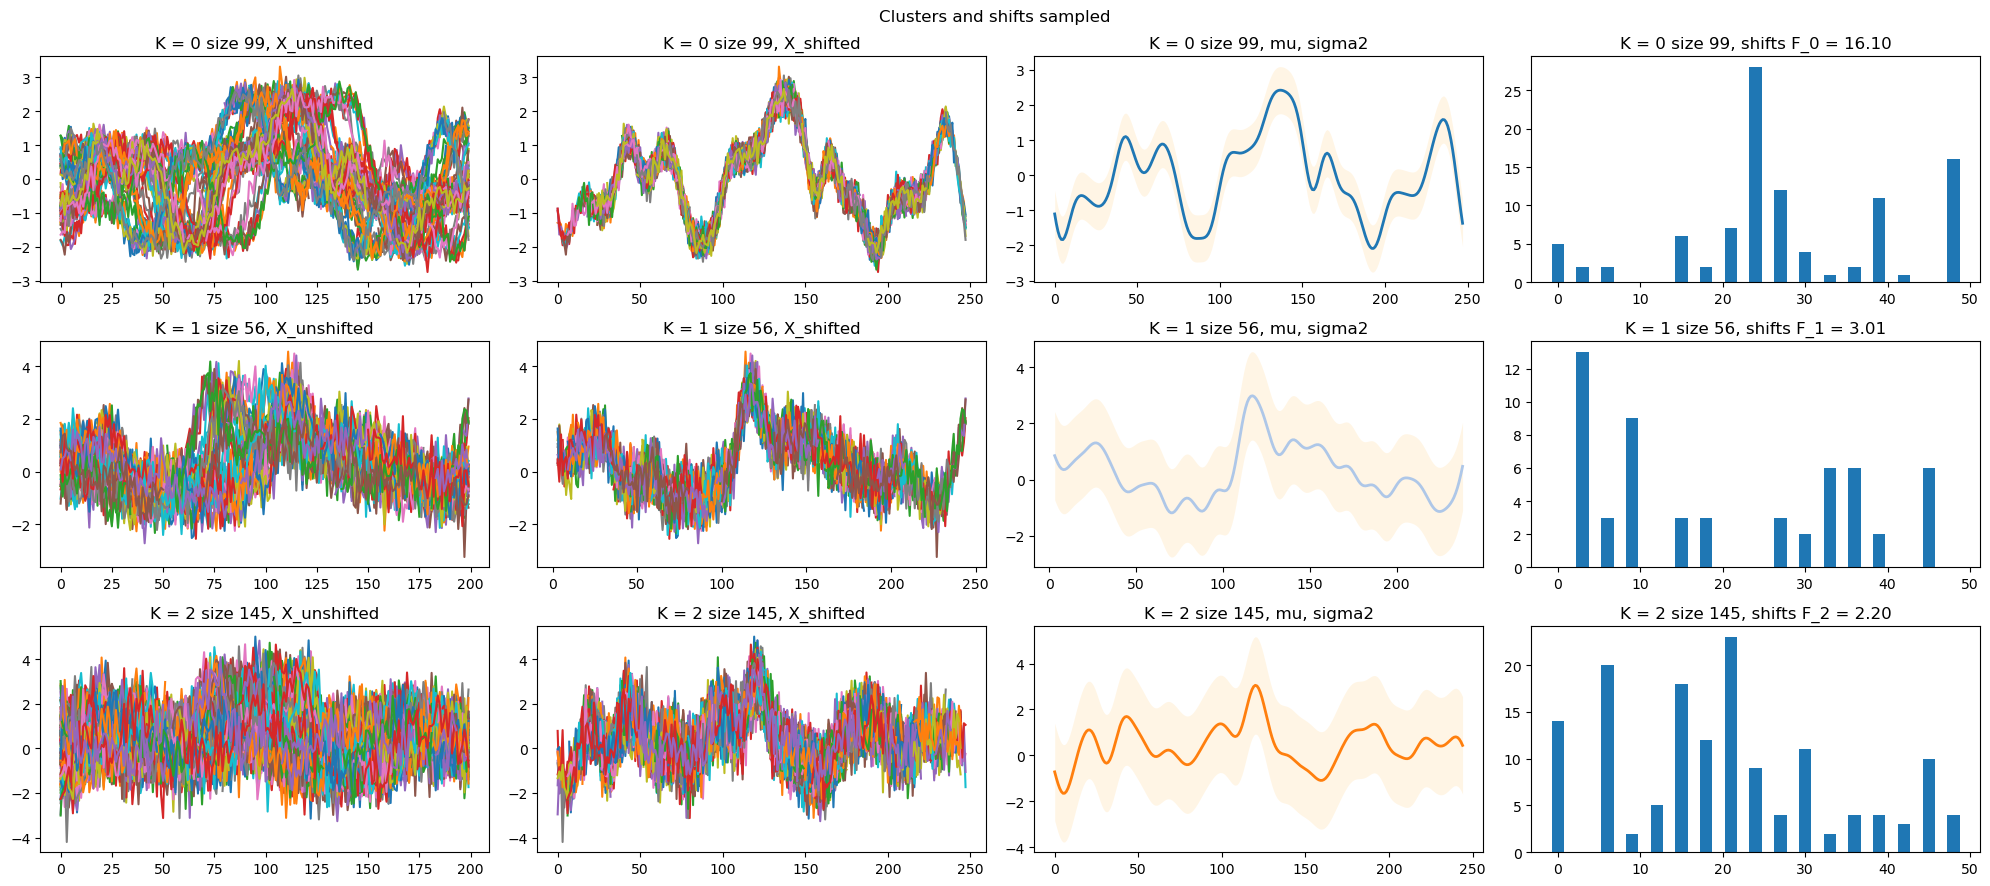

In [15]:
variance_reduction_factors = model_selection.compute_variance_reduction_factors(
    sampler.Z, sampler.K, sampler.tau_inds,
    sampler.X, sampler.S,
    sampler.constrained_sigma2, sampler.sigma2_zero, nu_zero,
    sampler.min_den, sampler.min_float
)

plotting.combined_plot(
    all_plots=all_plots,
    X=sampler.X,
    S=sampler.S,
    tau=sampler.tau,
    VS_tau=sampler.VS_tau,
    Z=sampler.Z,
    mu=sampler.mu,
    sigma2=sampler.sigma2,
    n_sigma=n_sigma,
    variance_reduction_factors=variance_reduction_factors,
    subfigsize=subfigsize,
)
plt.suptitle('Clusters and shifts sampled');

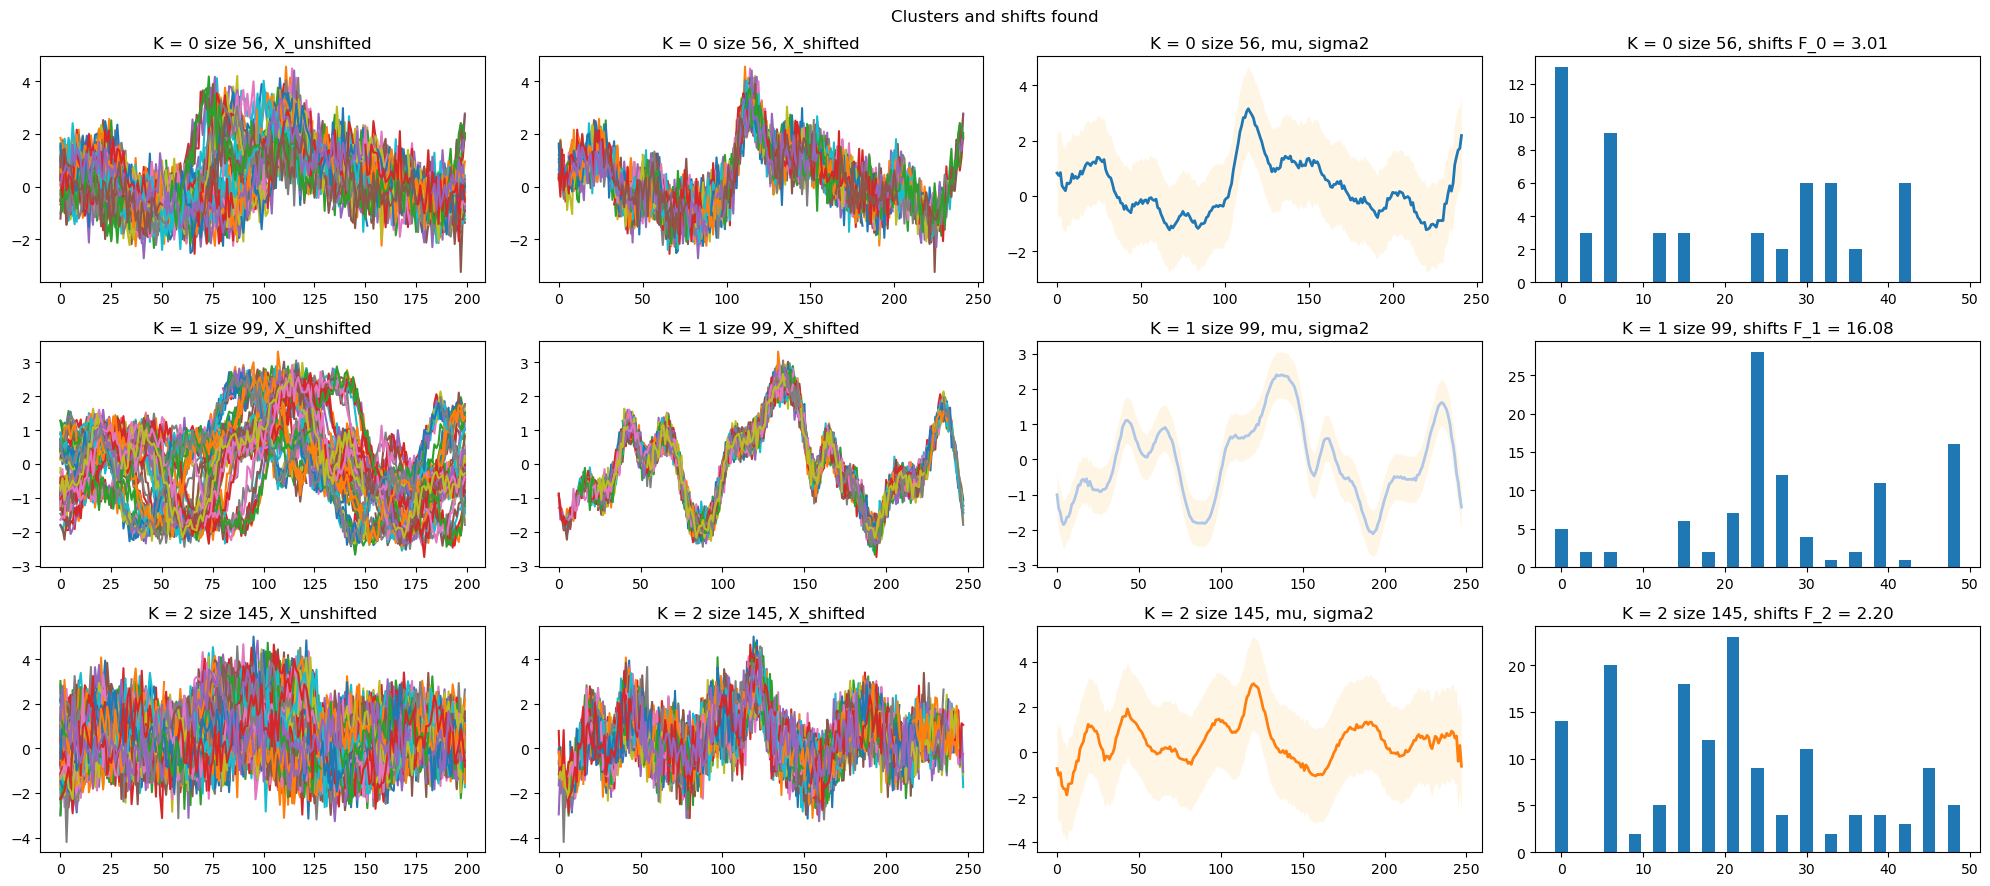

--- Fitting model with K = 4 and eta = 100.00
--- Initialzation plan:
    1 - Do 10 CEM runs
    2 - Take the 1 best partitions of the CEM runs
    3 - For each of the 1 starting points,run 5 VEM inits


--- Fitting the model in CEM


Setting global init partition with kmeans

Setting init shifts with sim

initialization # 1 on 10
initialization # 1 converged in sequential mode at iter 12


initialization # 2 on 10
initialization # 2 converged in sequential mode at iter 15


initialization # 3 on 10
initialization # 3 converged in sequential mode at iter 10


initialization # 4 on 10
initialization # 4 converged in sequential mode at iter 18


initialization # 5 on 10
initialization # 5 converged in sequential mode at iter 26


initialization # 6 on 10
initialization # 6 converged in sequential mode at iter 21


initialization # 7 on 10
initialization # 7 converged in sequential mode at iter 18


initialization # 8 on 10
initialization # 8 converged in sequential mode at iter 24


init

In [16]:
variance_reduction_factors = model_selection.compute_variance_reduction_factors(
    model_result.Z, model_result.K, model_result.tau_inds,
    model_result.X, model_result.S,
    model_result.constrained_sigma2, model_result.sigma2_zero, model_result.nu_zero,
    model_result.min_den, model_result.min_float
)

plotting.combined_plot(
    all_plots=all_plots,
    X=model_result.X,
    S=model_result.S,
    tau=model_result.tau,
    VS_tau=model_result.VS_tau,
    Z=model_result.Z,
    mu=model_result.mu,
    sigma2=model_result.sigma2,
    n_sigma=n_sigma,
    variance_reduction_factors=variance_reduction_factors,
    subfigsize=subfigsize,
)
plt.suptitle('Clusters and shifts found');